In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from numpy import mean
from sklearn.ensemble import StackingClassifier


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Load data

In [2]:
# load data from files
X_train = pd.read_csv("/kaggle/input/titanic/train.csv")
X_submission = pd.read_csv("/kaggle/input/titanic/test.csv")
y_train = X_train['Survived']

# remove y column
X_train = X_train.drop(columns='Survived')

## Data dictionary


|Variable|Definition|Key
|----|----|----
|survival|Survival|0 = No, 1 = Yes
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
|sex|Sex|
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic
|parch|# of parents / children aboard the Titanic
|ticket|Ticket number
|fare|Passenger fare
|cabin|Cabin number
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampto

# Preprocessing

In [3]:
X_train["Age"] = X_train["Age"].fillna(0)
X_submission["Age"] = X_submission["Age"].fillna(0)

X_train["Cabin"] = X_train["Cabin"].fillna(0)
X_submission["Cabin"] = X_submission["Cabin"].fillna(0)

X_train["Embarked"] = X_train["Embarked"].fillna(0)
X_submission["Embarked"] = X_submission["Embarked"].fillna(0)

In [4]:
# to use later for submission
X_submission_passengerId = X_submission['PassengerId']

X_train = X_train.drop(columns='Name')
X_train = X_train.drop(columns='Ticket')
X_train = X_train.drop(columns='PassengerId')
X_train = X_train.drop(columns='Pclass')
X_submission = X_submission.drop(columns='Name')
X_submission = X_submission.drop(columns='Ticket')
X_submission = X_submission.drop(columns='PassengerId')
X_submission = X_submission.drop(columns='Pclass')


In [5]:
cols_to_encode = ["Sex","Cabin","Embarked"]

enc = OrdinalEncoder()
for col in cols_to_encode:
    X_train[col] = X_train[col].astype('str')
    X_submission[col] = X_train[col].astype('str') 
    
enc.fit(X_train[cols_to_encode])
enc.categories_
X_train[cols_to_encode] = enc.transform(X_train[cols_to_encode])
X_submission[cols_to_encode] = enc.transform(X_submission[cols_to_encode])
print(X_train.head())
print(X_submission.head())

   Sex   Age  SibSp  Parch     Fare  Cabin  Embarked
0  1.0  22.0      1      0   7.2500    0.0       3.0
1  0.0  38.0      1      0  71.2833   82.0       1.0
2  0.0  26.0      0      0   7.9250    0.0       3.0
3  0.0  35.0      1      0  53.1000   56.0       3.0
4  1.0  35.0      0      0   8.0500    0.0       3.0
   Sex   Age  SibSp  Parch     Fare  Cabin  Embarked
0  1.0  34.5      0      0   7.8292    0.0       3.0
1  0.0  47.0      1      0   7.0000   82.0       1.0
2  0.0  62.0      0      0   9.6875    0.0       3.0
3  0.0  27.0      0      0   8.6625   56.0       3.0
4  1.0  22.0      1      1  12.2875    0.0       3.0


In [6]:
X_submission = X_submission.fillna(0)

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_submission = sc.fit_transform(X_submission)

# Ensemble / Stacking

>lr 0.787 (0.040)
>knn 0.796 (0.035)
>cart 0.776 (0.041)
>svm 0.811 (0.040)
>bayes 0.792 (0.045)


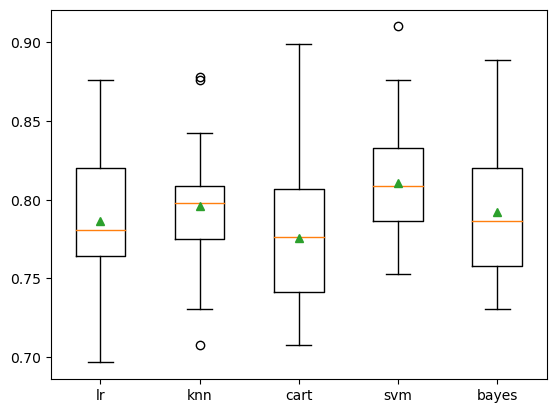

In [8]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['lr'] = LogisticRegression()
 models['knn'] = KNeighborsClassifier()
 models['cart'] = DecisionTreeClassifier()
 models['svm'] = SVC()
 models['bayes'] = GaussianNB()
 return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [9]:
def get_stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [10]:
def get_models():
 models = dict()
 models['lr'] = LogisticRegression()
 models['knn'] = KNeighborsClassifier()
 models['cart'] = DecisionTreeClassifier()
 models['svm'] = SVC()
 models['bayes'] = GaussianNB()
 models['stacking'] = get_stacking()
 return models

In [11]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

>lr 0.787 (0.040)
>knn 0.796 (0.035)
>cart 0.779 (0.041)
>svm 0.811 (0.040)
>bayes 0.792 (0.045)
>stacking 0.818 (0.041)


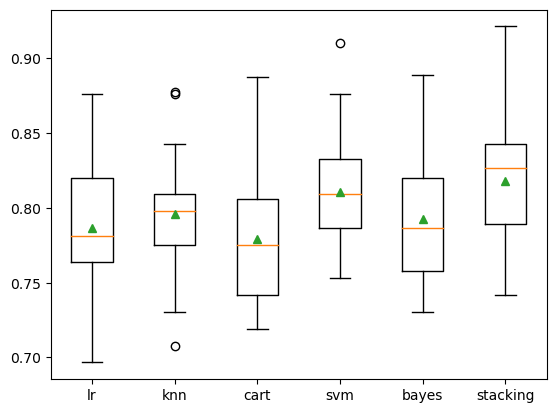

In [12]:
models = get_models()
results, names = list(), list()

for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Predict and submission

In [13]:
np.max(X_submission)

8.781044088387508

In [14]:
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(X_train, y_train)
y_pred = model.predict(X_submission)

In [15]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,

In [16]:
final_df = pd.DataFrame({'PassengerId': X_submission_passengerId, 'Survived': y_pred.astype(int).tolist()})
final_df.head(20)

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,1


In [17]:
final_df.to_csv('submission.csv', index=False)
print(" Submission saved")

 Submission saved
